In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import zscore
import itertools

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [3]:
tissue_list = ["Skin", "Pancreas", "Lung", "Kidney", "Colon", "Breast", "Bladder"]
top_three = ["Lung", "Breast", "Bladder"]

In [4]:
gene_df = []
genesintissue =[]
geneorder = []
for item in glob.glob("*cancertypecontrolled.csv"):
    start = item.split("_")[0]
    if start in top_three:
        print(item)
        tissue_tvalues = pd.read_csv(item, index_col = "Unnamed: 0")
        genesintissue.append(tissue_tvalues.columns.tolist())

columnintersection = list(set.intersection(*map(set,genesintissue)))

result_dataframe = []
for gene in columnintersection:
    gene_df = []
    columns = []
    for item in glob.glob("*cancertypecontrolled.csv"):
        start = item.split("_")[0]
        if start in top_three:
            tissue_tvalues = pd.read_csv(item, index_col = "Unnamed: 0")
            gene_df.append(pd.DataFrame(tissue_tvalues[gene]))
            columns.append(start)
    gene_tvalues = pd.concat(gene_df, axis =1)
    gene_tvalues = gene_tvalues.replace([np.inf, -np.inf], 0)
    gene_tvalues.columns = columns
    zscoredata = gene_tvalues.apply(zscore)
    
    correlations = {}
    for col_a, col_b in itertools.combinations(columns, 2):
        correlations[col_a + '__' + col_b] = spearmanr(zscoredata.loc[:, col_a], zscoredata.loc[:, col_b])
    
    result = pd.DataFrame.from_dict(correlations, orient='index')
    result.columns = ['PCC', 'p-value']
    result["Gene"] = gene
    geneorder.append([result["PCC"].mean(), gene])
    result_dataframe.append(result)

Bladder_mutationspecific_metabolites_cancertypecontrolled.csv
Breast_mutationspecific_metabolites_cancertypecontrolled.csv
Lung_mutationspecific_metabolites_cancertypecontrolled.csv


In [5]:
gene_order = pd.DataFrame(geneorder).sort_values(by = 0, ascending = False)[1].head(50).tolist()
gene_order = [k.split("_")[1] for k in gene_order]
combined_correlations = pd.concat(result_dataframe)
melted_combined_correlations = pd.melt(combined_correlations, value_vars=["PCC"], id_vars = ["Gene"])
melted_combined_correlations["Gene_split"] = melted_combined_correlations["Gene"].apply(lambda x: x.split("_")[1])

In [6]:
plt.rcParams['figure.figsize'] = [6, 14]

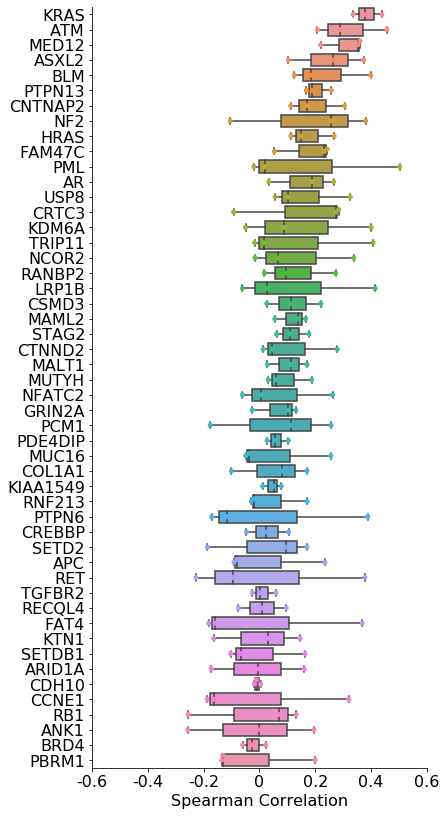

In [7]:
g= sns.boxplot(y =melted_combined_correlations["Gene_split"], x = melted_combined_correlations["value"], order = gene_order)
g2 = sns.swarmplot(y = melted_combined_correlations["Gene_split"], x = melted_combined_correlations["value"], order = gene_order, edgecolor = "k")
g.set_xlabel("Spearman Correlation", size = 16)
g.set_yticklabels(g.get_yticklabels(), size = 16)
g.set_xlim(-0.6, 0.6)
g.set_xticklabels([-0.6,-0.4,-0.2,0,0.2, 0.4, 0.6], size = 16)
g.set_ylabel("")

sns.despine()

#plt.savefig("Regression_correlation_top50mutations.pdf", bbox_inches = "tight")

In [33]:
specific = combined_correlations[combined_correlations["Gene"].isin(["T_TP53", "T_KRAS", "T_APC", "T_CCNE1"])]
melted_specific_correlations = pd.melt(specific, value_vars=["PCC"], id_vars = ["Gene"])
melted_specific_correlations["Gene_split"] = melted_specific_correlations["Gene"].apply(lambda x: x.split("_")[1])

In [34]:
plt.rcParams['figure.figsize'] = [6, 6]

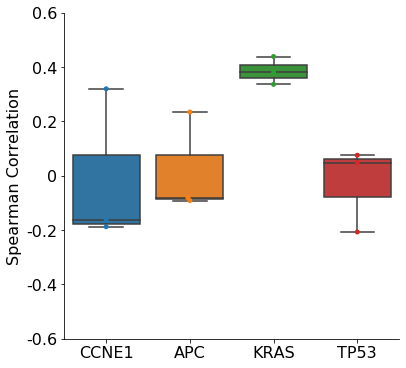

In [35]:
g= sns.boxplot(x =melted_specific_correlations["Gene_split"], y = melted_specific_correlations["value"])
g2 = sns.swarmplot(x = melted_specific_correlations["Gene_split"], y = melted_specific_correlations["value"], edgecolor = "k")
g.set_ylabel("Spearman Correlation", size = 16)
g.set_yticklabels([-0.6,-0.4,-0.2,0,0.2, 0.4, 0.6], size = 16)

g.set_xticklabels(g.get_xticklabels(), size = 16)
g.set_xlabel("", size = 16)


g.set_ylim(-0.6, 0.6)
sns.despine()

plt.savefig("KRAS_TP53_only_heterogeneity.pdf")

In [55]:
differential_metabolites = {}
gene_analysislist = ["T_KRAS"]
for gene in gene_analysislist:
    gene_df = []
    columns = []
    for item in glob.glob("*cancertypecontrolled.csv"):
        start = item.split("_")[0]
        if start in top_three:
            tissue_tvalues = pd.read_csv(item, index_col = "Unnamed: 0")
            gene_values = tissue_tvalues[gene]
            differentially_expressed = gene_values[abs(gene_values) >= 2.5]
            differential_metabolites[start] = differentially_expressed.index.tolist()
            
            gene_df.append(pd.DataFrame(tissue_tvalues[gene]))
            columns.append(start)
    gene_tvalues = pd.concat(gene_df, axis =1)
    gene_tvalues = gene_tvalues.replace([np.inf, -np.inf], 0)
    gene_tvalues.columns = columns
    zscoredata = gene_tvalues.apply(zscore)

In [56]:
from matplotlib_venn import venn3, venn3_circles

In [57]:
metabolites = pd.read_csv("../../AZ_data/Metabolite_reference_table.csv", index_col = "ionIdx")

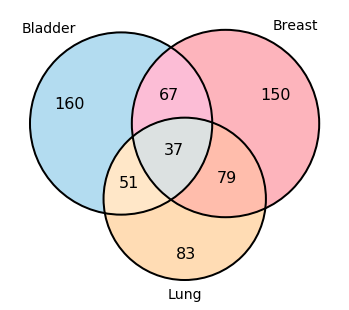

In [58]:
c = venn3([set(differential_metabolites["Bladder"]), set(differential_metabolites["Breast"]), set(differential_metabolites["Lung"])]
          , ("Bladder", "Breast", "Lung"))
v = venn3_circles([set(differential_metabolites["Bladder"]), set(differential_metabolites["Breast"]), set(differential_metabolites["Lung"])], linewidth=2, color="k")
c.get_patch_by_id('111').set_color('#A9B4B4')
c.get_patch_by_id('111').set_edgecolor('k')

c.get_patch_by_id('010').set_color('#fb4459')
c.get_patch_by_id('001').set_color('#ffa945')
c.get_patch_by_id('100').set_color('#43A9DB')

c.get_patch_by_id('110').set_color('#f95a99')
c.get_patch_by_id('011').set_color('#ff5a30')
c.get_patch_by_id('101').set_color('#ffc577')

for text in c.set_labels:
    text.set_fontsize(14)
for text in c.subset_labels:
    text.set_fontsize(16)

plt.savefig("KRAS_venn_v1.pdf", bbox_inches = "tight")

In [59]:
lung_unique_kras = list(set(differential_metabolites["Lung"])- (set(differential_metabolites["Breast"]))-(set(differential_metabolites["Bladder"])))

In [60]:
for item in metabolites.loc[lung_unique_kras]["name"].tolist():
    print(item)

Beta-Alanyl-CoA
Famotidine
PC(16:0/24:1(15Z))
PC(16:1(9Z)/24:0)
PC(18:0/22:1(13Z))
PC(18:1(11Z)/22:0)
PC(18:1(9Z)/22:0)
PC(20:0/20:1(11Z))
PC(20:1(11Z)/20:0)
PC(22:0/18:1(11Z))
PC(22:0/18:1(9Z))
PC(22:1(13Z)/18:0)
PC(24:0/15:0)
PC(24:0/16:1(9Z))
PC(24:1(15Z)/16:0)
Riboflavin reduced
MG(0:0/18:2(9Z,12Z)/0:0)
MG(18:2(9Z,12Z)/0:0/0:0)
3-O-Sulfogalactosylceramide (d18:1/24:1(15Z))
Tetracosahexaenoic acid
Pantetheine 4'-phosphate
2-Phenylaminoadenosine
1-Pyrroline-5-carboxylic acid
1-Pyrroline-2-carboxylic acid
Dynorphin A 1-8
Benzamide
Benzoic acid
4-Hydroxybenzaldehyde
PIP(16:0/22:2(13Z,16Z))
PIP(18:1(15Z)/20:1(11Z))
PIP(18:1(9Z)/20:1(11Z))
PIP(18:2(9Z,12Z)/20:0)
PIP(20:0/18:2(9Z,12Z))
PIP(20:1(11Z)/18:1(11Z))
PIP(20:1(11Z)/18:1(9Z))
PIP(20:2(11Z,14Z)/18:0)
PIP(22:2(13Z,16Z)/16:0)
2-O-(6-Phospho-alpha-mannosyl)-D-glycerate
Estradiol-17beta 3-sulfate
Urocanic acid
Nicotinamide N-oxide
Xanthurenate-8-O-beta-D-glucoside
D-Xylose
D-Ribose
2-Deoxyribonic acid
D-Ribulose
L-Arabinose
L-Threo-2-p

In [61]:
kras_shared = list(set(differential_metabolites["Lung"]) & (set(differential_metabolites["Breast"])) &(set(differential_metabolites["Bladder"])))

In [62]:
for item in metabolites.loc[kras_shared]["name"].tolist():
    print(item)

LysoPE(0:0/22:4(7Z,10Z,13Z,16Z))
LysoPE(22:4(7Z,10Z,13Z,16Z)/0:0)
LysoPE(0:0/22:0)
LysoPE(22:0/0:0)
PI(16:0/18:2(9Z,12Z))
PI(16:1(9Z)/18:1(11Z))
PI(16:1(9Z)/18:1(9Z))
PI(16:2(9Z,12Z)/18:0)
PI(18:0/16:2(9Z,12Z))
PI(18:1(11Z)/16:1(9Z))
PI(18:1(9Z)/16:1(9Z))
PI(18:2(9Z,12Z)/16:0)
Lipoyl-GMP
Aspartylglycosamine
PC(14:0/18:4(6Z,9Z,12Z,15Z))
PC(14:1(9Z)/18:3(6Z,9Z,12Z))
PC(14:1(9Z)/18:3(9Z,12Z,15Z))
PC(18:3(6Z,9Z,12Z)/14:1(9Z))
PC(18:3(9Z,12Z,15Z)/14:1(9Z))
PC(18:4(6Z,9Z,12Z,15Z)/14:0)
PE(15:0/20:4(5Z,8Z,11Z,14Z))
PE(15:0/20:4(8Z,11Z,14Z,17Z))
PE(20:4(5Z,8Z,11Z,14Z)/15:0)
PE(20:4(8Z,11Z,14Z,17Z)/15:0)
Behenic acid
Heptadecanoic acid
CPA(18:0/0:0)
Menthol
Decanal
Uridine diphosphate glucose
Uridine diphosphategalactose
D-Glucuronic acid 1-phosphate
GDP-L-fucose
GDP-D-Rhamnose
ADP-Mannose
ADP-glucose
Stearic acid
MG(0:0/18:1(11Z)/0:0)
MG(0:0/18:1(9Z)/0:0)
MG(18:1(11Z)/0:0/0:0)
MG(18:1(9Z)/0:0/0:0)
3-Hydroxydodecanoic acid
12-Hydroxydodecanoic acid
(R)-3-Hydroxydodecanoic acid
PC(15:0/20:5(5Z,8

In [63]:
differential_metabolites = {}
gene_analysislist = ["T_TP53"]
for gene in gene_analysislist:
    gene_df = []
    columns = []
    for item in glob.glob("*cancertypecontrolled.csv"):
        start = item.split("_")[0]
        if start in top_three:
            tissue_tvalues = pd.read_csv(item, index_col = "Unnamed: 0")
            gene_values = tissue_tvalues[gene]
            differentially_expressed = gene_values[abs(gene_values) >= 2.5]
            differential_metabolites[start] = differentially_expressed.index.tolist()
            
            gene_df.append(pd.DataFrame(tissue_tvalues[gene]))
            columns.append(start)
    gene_tvalues = pd.concat(gene_df, axis =1)
    gene_tvalues = gene_tvalues.replace([np.inf, -np.inf], 0)
    gene_tvalues.columns = columns
    zscoredata = gene_tvalues.apply(zscore)

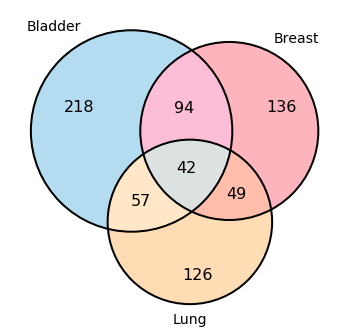

In [64]:
c = venn3([set(differential_metabolites["Bladder"]), set(differential_metabolites["Breast"]), set(differential_metabolites["Lung"])]
          , ("Bladder", "Breast", "Lung"))
v = venn3_circles([set(differential_metabolites["Bladder"]), set(differential_metabolites["Breast"]), set(differential_metabolites["Lung"])], linewidth=2, color="k")
c.get_patch_by_id('111').set_color('#A9B4B4')
c.get_patch_by_id('111').set_edgecolor('k')

c.get_patch_by_id('010').set_color('#fb4459')
c.get_patch_by_id('001').set_color('#ffa945')
c.get_patch_by_id('100').set_color('#43A9DB')

c.get_patch_by_id('110').set_color('#f95a99')
c.get_patch_by_id('011').set_color('#ff5a30')
c.get_patch_by_id('101').set_color('#ffc577')

for text in c.set_labels:
    text.set_fontsize(14)
for text in c.subset_labels:
    text.set_fontsize(16)
    
plt.savefig("TP53_venn_v1.pdf", bbox_inches = "tight")

In [65]:
breast_unique_tp53 = list(set(differential_metabolites["Breast"])- (set(differential_metabolites["Lung"]))-(set(differential_metabolites["Bladder"])))

In [66]:
for item in metabolites.loc[breast_unique_tp53]["name"].tolist():
    print(item)

2-O-a-L-Fucopyranosyl-galactose
3-O-a-L-Fucopyranosyl-D-glucose
PS(18:3(9Z,12Z,15Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))
PS(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/18:3(9Z,12Z,15Z))
PC(16:0/22:4(7Z,10Z,13Z,16Z))
PC(18:0/20:4(5Z,8Z,11Z,14Z))
PC(18:0/20:4(8Z,11Z,14Z,17Z))
PC(18:1(11Z)/20:3(5Z,8Z,11Z))
PC(18:1(11Z)/20:3(8Z,11Z,14Z))
PC(18:1(9Z)/20:3(5Z,8Z,11Z))
PC(18:1(9Z)/20:3(8Z,11Z,14Z))
PC(18:2(9Z,12Z)/20:2(11Z,14Z))
PC(18:3(6Z,9Z,12Z)/20:1(11Z))
PC(18:3(9Z,12Z,15Z)/20:1(11Z))
PC(18:4(6Z,9Z,12Z,15Z)/20:0)
PC(20:0/18:4(6Z,9Z,12Z,15Z))
PC(20:1(11Z)/18:3(6Z,9Z,12Z))
PC(20:1(11Z)/18:3(9Z,12Z,15Z))
PC(20:2(11Z,14Z)/18:2(9Z,12Z))
PC(20:3(5Z,8Z,11Z)/18:1(11Z))
PC(20:3(5Z,8Z,11Z)/18:1(9Z))
PC(20:3(8Z,11Z,14Z)/18:1(11Z))
PC(20:3(8Z,11Z,14Z)/18:1(9Z))
PC(20:4(5Z,8Z,11Z,14Z)/18:0)
PC(20:4(8Z,11Z,14Z,17Z)/18:0)
PC(22:4(7Z,10Z,13Z,16Z)/16:0)
9,12,13-TriHOME
9,10,13-TriHOME
PC(18:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))
PC(18:1(11Z)/22:5(4Z,7Z,10Z,13Z,16Z))
PC(18:1(11Z)/22:5(7Z,10Z,13Z,16Z,19Z))
PC(18:1(9Z)/22:5(4Z,7Z,10Z,13Z,1

In [67]:
bladder_unique_tp53 = list(set(differential_metabolites["Bladder"])- (set(differential_metabolites["Lung"]))-(set(differential_metabolites["Breast"])))

In [68]:
for item in metabolites.loc[bladder_unique_tp53]["name"].tolist():
    print(item)

Homophytanic acid
Heneicosanoic acid
Acetaminophen glucuronide
Propyl alcohol
Isopropyl alcohol
Olanzapine
Acrylamide
PS(18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))
PS(20:3(8Z,11Z,14Z)/20:4(5Z,8Z,11Z,14Z))
PS(20:4(5Z,8Z,11Z,14Z)/20:3(8Z,11Z,14Z))
PS(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/18:1(9Z))
PS(18:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))
PS(20:3(8Z,11Z,14Z)/20:3(8Z,11Z,14Z))
PS(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/18:0)
Methyl propenyl ketone
3-Methyl-2-butenal
Malonyl-CoA
Pyruvic acid
Malonic semialdehyde
Butyric acid
Isobutyric acid
Acetoin
Beta-Alanine
L-Alanine
Sarcosine
D-Alanine
L-Lactic acid
Hydroxypropionic acid
Glyceraldehyde
D-Lactic acid
Dihydroxyacetone
Succinyl-CoA
Methylmalonyl-CoA
R-Methylmalonyl-CoA
S-Methylmalonyl-CoA
2-Methyl-3-hydroxybutyryl-CoA
3-Hydroxyisovaleryl-CoA
Dimethyldisulfide
Dimethyl sulfone
Propylene glycol
(S)-Propane-1,2-diol
3b,15b,17a-Trihydroxy-pregnenone
3b,17a,21-Trihydroxypregnenone
3a,21-Dihydroxy-5b-pregnane-11,20-dione
11b,21-Dihydroxy-5b-pregnane-3,20-dione
17a,21-Dihydro

In [69]:
TP53_shared = list(set(differential_metabolites["Lung"]) & (set(differential_metabolites["Breast"])) &(set(differential_metabolites["Bladder"])))

In [70]:
for item in metabolites.loc[TP53_shared]["name"].tolist():
    print(item)

PC(14:0/P-16:0)
PE(15:0/P-18:0)
PC(P-16:0/14:0)
PE(P-18:0/15:0)
PC(o-14:0/16:1(9Z))
PC(o-16:0/14:1(9Z))
LysoPE(0:0/22:1(13Z))
LysoPE(22:1(13Z)/0:0)
PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))
PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))
PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)
PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))
PE(P-18:1(11Z)/18:4(6Z,9Z,12Z,15Z))
PE(P-18:1(9Z)/18:4(6Z,9Z,12Z,15Z))
2-Aminomuconic acid
Kinetensin 4-7
Inosinic acid
Inosine 2'-phosphate
Cholic acid glucuronide
DG(14:0/18:2(9Z,12Z)/0:0)
DG(14:1(9Z)/18:1(11Z)/0:0)
DG(14:1(9Z)/18:1(9Z)/0:0)
DG(16:1(9Z)/16:1(9Z)/0:0)
DG(18:1(11Z)/14:1(9Z)/0:0)
DG(18:1(9Z)/14:1(9Z)/0:0)
DG(18:2(9Z,12Z)/14:0/0:0)
LPA(0:0/18:1(9Z))
LPA(18:1(9Z)/0:0)
DHAP(18:0)
PC(20:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))
PC(20:1(11Z)/22:5(4Z,7Z,10Z,13Z,16Z))
PC(20:1(11Z)/22:5(7Z,10Z,13Z,16Z,19Z))
PC(20:2(11Z,14Z)/22:4(7Z,10Z,13Z,16Z))
PC(20:4(5Z,8Z,11Z,14Z)/22:2(13Z,16Z))
PC(20:4(8Z,11Z,14Z,17Z)/22:2(13Z,16Z))
PC(20:5(5Z,8Z,11Z,14Z,17Z)/22:1(13Z))
PC(22:1(13Z)/20:5(5Z,8Z,11Z,14Z,17Z))
PC(22:2(1

In [82]:
## KRAS LUNG
kras_lung = pd.read_csv("./KRAS_lung_only/pathway_results.csv", index_col = "Unnamed: 0")

In [83]:
kras_lung.columns = ["Total","Expected","Hits","Raw p", "-log10(pvalue)","Holm adjust","FDR","Pathway Impact"]

In [84]:
plt.rcParams['figure.figsize'] = [6,6]

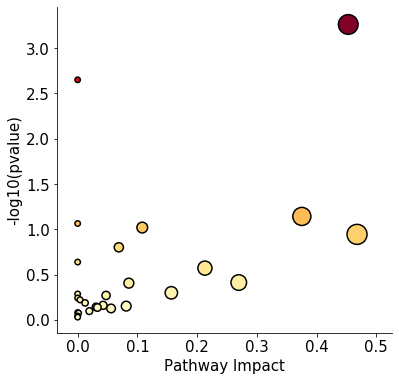

In [85]:
#palette_cmap = sns.diverging_palette(237, 8.7, s= 99, l = 50, as_cmap = True)
palette_cmap = sns.color_palette("YlOrRd", as_cmap=True)
#sns.set(font_scale=1)
g = sns.scatterplot(x = "Pathway Impact", y = "-log10(pvalue)", data = kras_lung, size="Pathway Impact", sizes = (30, 400)
                , hue = "-log10(pvalue)", palette = palette_cmap, edgecolor = "k", linewidth = 1.5, legend = False)
sns.despine()
g.tick_params(labelsize=15)
g.set_xlabel("Pathway Impact", size=15)
g.set_ylabel("-log10(pvalue)", size = 15)

plt.savefig("KRAS_lung_only_pathways.pdf")

In [76]:
## KRAS ALL
kras_all = pd.read_csv("./KRAS_combined/pathway_results.csv", index_col = "Unnamed: 0")

In [77]:
kras_all.columns = ["Total","Expected","Hits","Raw p", "-log10(pvalue)","Holm adjust","FDR","Pathway Impact"]

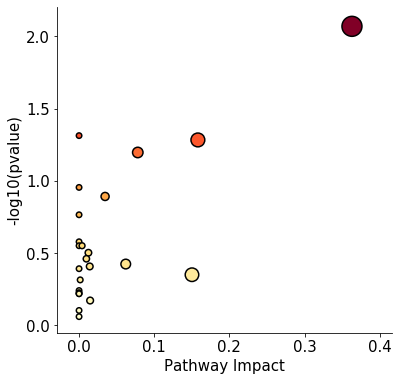

In [86]:
#palette_cmap = sns.diverging_palette(237, 8.7, s= 99, l = 50, as_cmap = True)
palette_cmap = sns.color_palette("YlOrRd", as_cmap=True)
#sns.set(font_scale=1)
g = sns.scatterplot(x = "Pathway Impact", y = "-log10(pvalue)", data = kras_all, size="Pathway Impact", sizes = (30, 400)
                , hue = "-log10(pvalue)", palette = palette_cmap, edgecolor = "k", linewidth = 1.5, legend = False)
sns.despine()
g.tick_params(labelsize=15)
g.set_xlabel("Pathway Impact", size=15)
g.set_ylabel("-log10(pvalue)", size = 15)
#g.set_xlim(0,0.4)

plt.savefig("KRAS_joint_pathways.pdf")

In [87]:
## TP53 bladder
TP53_bladder = pd.read_csv("./TP53_bladder_only/pathway_results.csv", index_col = "Unnamed: 0")

In [88]:
TP53_bladder.columns = ["Total","Expected","Hits","Raw p", "-log10(pvalue)","Holm adjust","FDR","Pathway Impact"]

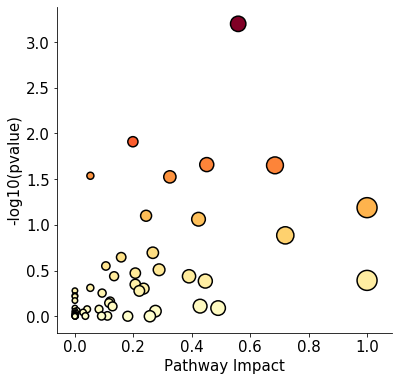

In [91]:
#palette_cmap = sns.diverging_palette(237, 8.7, s= 99, l = 50, as_cmap = True)
palette_cmap = sns.color_palette("YlOrRd", as_cmap=True)
#sns.set(font_scale=1)
g = sns.scatterplot(x = "Pathway Impact", y = "-log10(pvalue)", data = TP53_bladder, size="Pathway Impact", sizes = (30, 400)
                , hue = "-log10(pvalue)", palette = palette_cmap, edgecolor = "k", linewidth = 1.5, legend = False)
sns.despine()
g.tick_params(labelsize=15)
g.set_xlabel("Pathway Impact", size=15)
g.set_ylabel("-log10(pvalue)", size = 15)
#g.set_xlim(0,0.4)

plt.savefig("TP53_bladder_pathways.pdf")

In [92]:
## TP53 all
TP53_joint = pd.read_csv("./TP53_combined/pathway_results.csv", index_col = "Unnamed: 0")

In [93]:
TP53_joint.columns = ["Total","Expected","Hits","Raw p", "-log10(pvalue)","Holm adjust","FDR","Pathway Impact"]

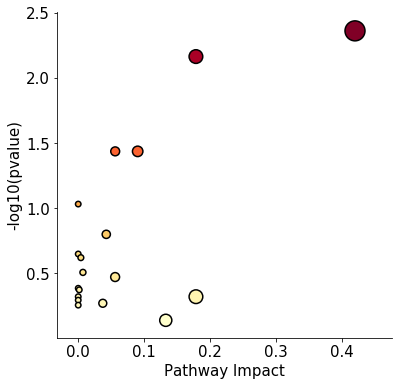

In [95]:
#palette_cmap = sns.diverging_palette(237, 8.7, s= 99, l = 50, as_cmap = True)
palette_cmap = sns.color_palette("YlOrRd", as_cmap=True)
#sns.set(font_scale=1)
g = sns.scatterplot(x = "Pathway Impact", y = "-log10(pvalue)", data = TP53_joint, size="Pathway Impact", sizes = (30, 400)
                , hue = "-log10(pvalue)", palette = palette_cmap, edgecolor = "k", linewidth = 1.5, legend = False)
sns.despine()
g.tick_params(labelsize=15)
g.set_xlabel("Pathway Impact", size=15)
g.set_ylabel("-log10(pvalue)", size = 15)

plt.savefig("TP53_joint_pathways.pdf")